In [ ]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from datetime import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler

In [ ]:
class CryptoPricePredictor:
    def __init__(self, data_file, sequence_length=10, learning_rate=0.001):
        self.data = pd.read_csv(data_file)
        self.sequence_length = sequence_length
        self.learning_rate = learning_rate

    def preprocess_data(self):
        label_encoder = LabelEncoder()
        self.data['tickDirection'] = label_encoder.fit_transform(self.data['tickDirection'])

        # Feature scaling
        scaler = StandardScaler()
        numerical_cols = ['close', 'high', 'low', 'open', 'tick_volume', 'bid', 'ask']
        self.data[numerical_cols] = scaler.fit_transform(self.data[numerical_cols])

    def create_sequences(self, data, sequence_length):
        sequences = []
        for i in range(len(data) - sequence_length):
            seq = data[i:i + sequence_length]
            sequences.append(seq)
        return np.array(sequences)

    def train_test_split(self, test_size=0.2):
        X = self.data.drop(columns=['last'])
        y = self.data['last']

        X_seq = self.create_sequences(X.values, self.sequence_length)
        y_seq = y[self.sequence_length:].values

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X_seq, y_seq, test_size=test_size, random_state=42)

        # Print shapes for debugging
        print(f'X_train shape: {self.X_train.shape}')
        print(f'X_test shape: {self.X_test.shape}')
        print(f'y_train shape: {self.y_train.shape}')
        print(f'y_test shape: {self.y_test.shape}')

    def build_complex_rnn_model(self):
        # Verify the shape of X_train before building the model
        if len(self.X_train.shape) != 3:
            raise ValueError(f'Expected X_train to have 3 dimensions (samples, timesteps, features), but got shape: {self.X_train.shape}')

        model = Sequential()
        model.add(LSTM(128, return_sequences=True, input_shape=(self.sequence_length, self.X_train.shape[2])))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())

        model.add(LSTM(128, return_sequences=True))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())

        model.add(LSTM(64))
        model.add(Dropout(0.1))
        model.add(BatchNormalization())

        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.1))
        model.add(Dense(1))

        optimizer = Adam(learning_rate=self.learning_rate)
        model.compile(optimizer=optimizer, loss='mse')
        return model

    def train_model(self, model):
        # Define the ModelCheckpoint and EarlyStopping callbacks
        checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

        # Define LearningRateScheduler callback if needed (optional)
        def lr_schedule(epoch, lr):
            if epoch > 10:
                lr = lr * 0.5
            return lr

        lr_scheduler = LearningRateScheduler(lr_schedule)

        # Train the model with the callbacks
        model.fit(self.X_train, self.y_train, epochs=50, batch_size=32, verbose=1,
                  validation_split=0.2, callbacks=[checkpoint, early_stopping, lr_scheduler])

    def evaluate_model(self, model):
        predictions = model.predict(self.X_test)
        mse = mean_squared_error(self.y_test, predictions)
        return mse

    def plot_data(self):
        # Plot data distribution before preprocessing
        self.data.hist(figsize=(12, 10))
        plt.suptitle('Data Distribution Before Preprocessing')
        plt.show()

    def save_model(self, model, filename):
        model.save(filename)

In [ ]:
crypto_predictor = CryptoPricePredictor('crypto_data_sub.csv', sequence_length=10, learning_rate=0.001)

In [ ]:
crypto_predictor.data.head()

,tickDirection,last,close,high,low,open,tick_volume,bid,ask
0,ZeroMinusTick,49641.8,48142.2,50000.0,47712.8,49527.6,157242.780,49641.8,49641.9
1,ZeroMinusTick,49637.2,48142.2,50000.0,47712.8,49527.6,157242.780,49637.1,49637.2
2,MinusTick,49649.2,48142.2,50000.0,47712.8,49527.6,157242.780,49649.2,49649.3
3,ZeroPlusTick,49650.0,48142.2,50000.0,47712.8,49527.6,157242.780,49649.9,49650.0
4,PlusTick,49655.0,48142.2,50000.0,47712.8,49527.6,157247.882,49654.9,49655.0


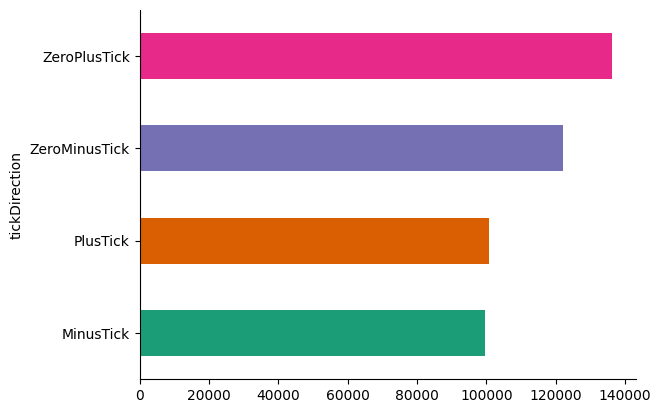

In [ ]:
crypto_predictor.data.groupby('tickDirection').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
crypto_predictor.preprocess_data()

In [ ]:
crypto_predictor.data.head()

,tickDirection,last,close,high,low,open,tick_volume,bid,ask
0,2,49641.8,-1.237812,-1.226012,-1.186907,-1.20861,-0.080371,-1.199365,-1.199366
1,2,49637.2,-1.237812,-1.226012,-1.186907,-1.20861,-0.080371,-1.199907,-1.199908
2,0,49649.2,-1.237812,-1.226012,-1.186907,-1.20861,-0.080371,-1.198513,-1.198513
3,3,49650.0,-1.237812,-1.226012,-1.186907,-1.20861,-0.080371,-1.198432,-1.198433
4,1,49655.0,-1.237812,-1.226012,-1.186907,-1.20861,-0.080250,-1.197856,-1.197856


In [ ]:
crypto_predictor.train_test_split()

X_train shape: (366837, 10, 8)
X_test shape: (91710, 10, 8)
y_train shape: (366837,)
y_test shape: (91710,)


In [ ]:
model = crypto_predictor.build_complex_rnn_model()

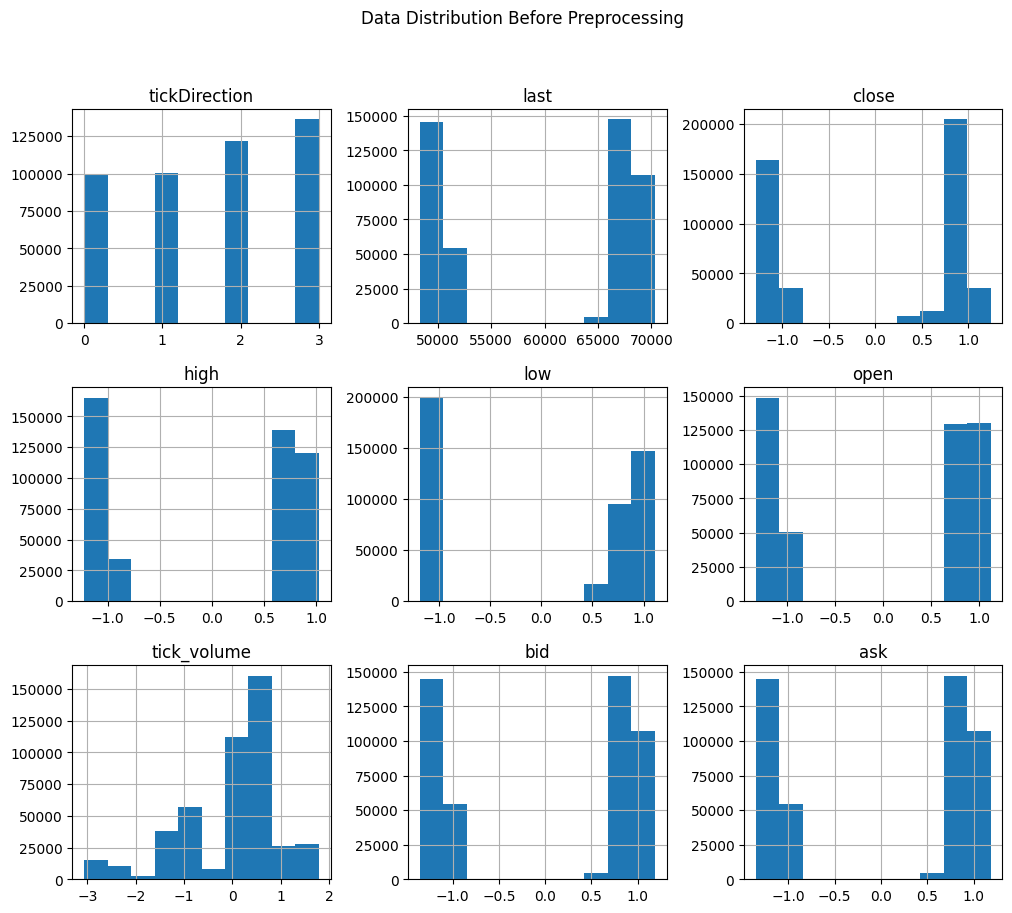

In [ ]:
crypto_predictor.plot_data()

In [ ]:
crypto_predictor.train_model(model)

Epoch 1/50
9171/9171 [==============================] - ETA: 0s - loss: 541750720.0000
Epoch 1: val_loss improved from inf to 1758012.87500, saving model to best_model.h5
9171/9171 [==============================] - 300s 32ms/step - loss: 541750720.0000 - val_loss: 1758012.8750 - lr: 0.0010
Epoch 2/50
   5/9171 [..............................] - ETA: 4:08 - loss: 346194656.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9171/9171 [==============================] - ETA: 0s - loss: 47899608.0000
Epoch 2: val_loss improved from 1758012.87500 to 1536960.87500, saving model to best_model.h5
9171/9171 [==============================] - 298s 32ms/step - loss: 47899608.0000 - val_loss: 1536960.8750 - lr: 0.0010
Epoch 3/50
9170/9171 [============================>.] - ETA: 0s - loss: 20103980.0000
Epoch 3: val_loss did not improve from 1536960.87500
9171/9171 [==============================] - 300s 33ms/step - loss: 20103166.0000 - val_loss: 2654661.0000 - lr: 0.0010
Epoch 4/50
9171/9171 [==============================] - ETA: 0s - loss: 16690511.0000
Epoch 4: val_loss improved from 1536960.87500 to 499661.87500, saving model to best_model.h5
9171/9171 [==============================] - 298s 32ms/step - loss: 16690511.0000 - val_loss: 499661.8750 - lr: 0.0010
Epoch 5/50
9170/9171 [============================>.] - ETA: 0s - loss: 14093516.0000
Epoch 5: val_loss improved from 499661.87500 to 306680.28125, saving

In [ ]:
crypto_predictor.evaluate_model(model)

2866/2866 [==============================] - 37s 12ms/step


75305.83547046456

In [ ]:
crypto_predictor.X_test[0]

array([[ 2.        , -1.13472869, -0.9932159 , -1.04101301, -0.98513377,
         0.46989361, -1.00165383, -1.00165457],
       [ 0.        , -1.13472869, -0.9932159 , -1.04101301, -0.98513377,
         0.46989361, -1.0016423 , -1.00164304],
       [ 3.        , -1.13472869, -0.9932159 , -1.04101301, -0.98513377,
         0.46989361, -1.00128507, -1.00128581],
       [ 3.        , -1.13472869, -0.9932159 , -1.04101301, -0.98513377,
         0.46989361, -1.00113526, -1.001136  ],
       [ 2.        , -1.13472869, -0.9932159 , -1.04101301, -0.98513377,
         0.46989361, -1.00113526, -1.001136  ],
       [ 0.        , -1.13472869, -0.9932159 , -1.04101301, -0.98513377,
         0.47011625, -1.00113526, -1.001136  ],
       [ 0.        , -1.13472869, -0.9932159 , -1.04101301, -0.98513377,
         0.47011625, -1.00190735, -1.00190809],
       [ 0.        , -1.13472869, -0.9932159 , -1.04101301, -0.98513377,
         0.47011625, -1.00190735, -1.00190809],
       [ 1.        , -1.13472869

In [ ]:
current_datetime = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_filename = f"crypto_price_predictor_model_{current_datetime}.h5"
crypto_predictor.save_model(model, model_filename)
print(f"Model saved as '{model_filename}' for future use.")

Model saved as 'crypto_price_predictor_model_2024-05-16_23-03-21.h5' for future use.


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
